In [ ]:
import numpy as np
from qiskit.quantum_info.operators.symplectic import SparsePauliOp
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from bitstring import BitArray
from collections import Counter
import copy
import wojciech_remastered as wo

In [2]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

In [3]:
def all_config(size):
    all_pat = []
    for i in range(size-1):
        for j in range(size-1-i):
            for v1 in range(2):
                for v2 in range(2):
                    all_pat.append( [[1,1]]*i + bin_to_pattern(str(v1)) + [[1,1]]*j + bin_to_pattern(str(v2)) + [[1,1]]*(size-i-j-2))
    return all_pat

In [4]:
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats

In [5]:
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats

In [6]:
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
# create_specific_patterns4(0,1,2,4,N)

In [7]:
def overlapp(x,measurement):
    return np.prod( [np.dot(p1,p2) for p1,p2 in zip(x,measurement)] )

In [8]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

In [9]:
def compute_hamiltonian(all_pat,y):

    H = 0

    for p,yi in zip(all_pat,y):

        if yi==0:
            continue
        
        ops = []
        for t in p:
            if t == [0,1]:
                coefs = [1/2,-1/2]
            elif t == [1,0]:
                coefs = [1/2,1/2]
            else:
                coefs = [1,0]
            ops.append(SparsePauliOp(["I","Z"],coefs))
        op = ops[0]
        for i in range(1,len(ops)):
            op = op.tensor(ops[i]).simplify()
        H = (H + (op * yi[0])).simplify()

    return np.real_if_close(H.coeffs),H.paulis

# H,paulis_idx = compute_hamiltonian(all_pat,y)
# for pstring,coef in zip(paulis_idx,H):
#     print(pstring,coef)

In [10]:
def paulis_to_gates(pauli_string):
    return [i for i,s in enumerate(pauli_string) if s=='Z']

In [11]:
def obj_func(z):
    v = BitArray(bin='0'+z).int
    return (A.T[v] * y)[0,0]


def compute_expectation(counts):
        
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = -obj_func(bitstring)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_qaoa_circ(theta,paulis_idx,H):

    nqubits = N
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

        for pstring,coef in zip(paulis_idx,H):
            if coef!=0:
                idx = paulis_to_gates(str(pstring))
                if len(idx)==1:
                    qc.rz(2*gamma[irep]*coef,idx[0])
                elif len(idx)==2:
                    qc.rzz(2*gamma[irep]*coef,idx[0],idx[1])
                elif len(idx)==3:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.rz(2*gamma[irep]*coef,idx[2])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])
                elif len(idx)==4:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[2],idx[3])
                    qc.rz(2*gamma[irep]*coef,idx[3])
                    qc.cnot(idx[2],idx[3])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])

    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(paulis_idx,H,shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta,paulis_idx,H)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

<h2>Metric functions def</h2>

In [306]:
def sparse_to_full(vector,size):
    v = np.zeros(size)
    for pos,val in vector:
        v[int(pos)] += val
    return v

In [231]:
#Recovery/Reconstruction Error (best = 0)
#+-= MSE (at final time)

def recoveryErr(x_original, x_reconstructed,N):
    return np.linalg.norm(x_original - x_reconstructed) / np.linalg.norm(x_original)

In [232]:
#Covariance (useless?)
def cov(x_original, x_reconstructed,N):
    return np.mean( (x_original - np.mean(x_original)) * (x_reconstructed - np.mean(x_reconstructed)) )

In [233]:
#Correlation (best = 1)
def correl(x_original, x_reconstructed,N):
    return cov(x_original,x_reconstructed,N) / (np.std(x_original) * np.std(x_reconstructed))

In [346]:
#Recovery Signal to noise ratio
def RSNR(x_original, x_reconstructed,N):
    return min(np.linalg.norm(x_original)**2 / np.mean(np.linalg.norm(x_original - x_reconstructed)**2),1000)

In [274]:
#Error sparsity (best = 1)
def ErrSparsity(original, reconstructed):
    return len(original)/len(reconstructed)

<h2>Main Test</h2>

In [496]:
#Classical NN
N = 6
s = 3                       #Sparsity

recov_errs = []
correls = []
RSNRs = []
err_spar = []

all_pat = []
for i in range(N-1):
    all_pat += create_specific_patterns(i,i+1,N)

for nb in range(1000):
    
    #Random sparse spectrum
    spec = np.arange(2**N)
    np.random.shuffle(spec)
    spec = list(spec[:s])
    spec.sort()
    spec_val = np.random.randint(50,100,s)

    bin_spec = []
    for x in spec:
        bin_x = "{0:b}".format(x)
        bin_spec.append('0'*(N-len(bin_x)) + bin_x)

    pat_spec = [bin_to_pattern(bin_x) for bin_x in bin_spec] 

    y = np.zeros((len(all_pat),1))
    for pat,val in zip(pat_spec,spec_val):
        y += np.matrix([overlapp(pat,p)*val for p in all_pat]).T

    st = 1
    itnum = 100

    x_recov = wo.Matchpurising(y[:,0],st,itnum,N,2,2)

    x_origin = [[i,j] for i,j in zip(spec,spec_val)]

    x_original = sparse_to_full(x_origin,2**N)
    x_reconstructed = sparse_to_full(x_recov,2**N)

    x_original = x_original/np.linalg.norm(x_original)
    x_reconstructed = x_reconstructed/np.linalg.norm(x_reconstructed)

    recov_errs.append( recoveryErr(x_original,x_reconstructed,N) )
    correls.append( correl(x_original,x_reconstructed,N) )
    RSNRs.append( RSNR(x_original,x_reconstructed,N) )
    err_spar.append( ErrSparsity(x_origin,x_recov) )

# print(x_origin)
# print(x_recov)

# print(np.linalg.norm(x_original))
# print(np.linalg.norm(x_reconstructed))

print(np.mean(recov_errs))
print(np.mean(correls))
print(np.mean(RSNRs))
print(np.mean(err_spar))

0.966667441813087
0.457085594536686
1.7689749001688277
0.6574175053403768


In [444]:
# from collections import OrderedDict

# hist = Counter(np.array(recov_errs).round(decimals=1))
# ind = []
# valu = []
# for i,j in hist.items():
#     ind.append(i)
#     valu.append(j)

# plt.bar(ind,valu)
# plt.plot()

In [495]:
#Quantum NN
N = 6
s = 3                       #Sparsity

train_params = np.arange(5,35,5)
print(train_params)

recov_errs = {}
correls = {}
RSNRs = {}
err_spar = {}

for p in train_params:
    recov_errs[p] = []
    correls[p] = []
    RSNRs[p] = []
    err_spar[p] = []

all_pat = []
for i in range(N-1):
    all_pat += create_specific_patterns(i,i+1,N)

for nb in range(40):
    print(nb)
    
    #Random sparse spectrum
    spec = np.arange(2**N)
    np.random.shuffle(spec)
    spec = list(spec[:s])
    spec.sort()
    spec_val = np.random.randint(50,100,s)

    bin_spec = []
    for x in spec:
        bin_x = "{0:b}".format(x)
        bin_spec.append('0'*(N-len(bin_x)) + bin_x)

    pat_spec = [bin_to_pattern(bin_x) for bin_x in bin_spec] 
    
    y = np.zeros((len(all_pat),1))
    for pat,val in zip(pat_spec,spec_val):
        y += np.matrix([overlapp(pat,p)*val for p in all_pat]).T
    A = np.matrix([ dev_pattern(p) for p in all_pat])

    for ind,p in enumerate(train_params):

        # print(p)

        st = 15
        x_recov = []

        for i in range(5):

            H, paulis_idx = compute_hamiltonian(all_pat,y)

            expectation = get_expectation(paulis_idx,H)

            res = minimize(expectation, 
                                np.ones(p), 
                                method='COBYLA')
            backend = Aer.get_backend('aer_simulator')
            backend.shots = 512

            qc_res = create_qaoa_circ(res.x,paulis_idx,H)
            counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

            z = list(counts.keys())[np.argmax(list(counts.values()))]
            v = BitArray(bin='0'+z).int

            x_recov.append(v)
            y -= (0.05*((A.T[v]*y)[0,0]) * A.T[v]).T

        x_origin = [[i,j] for i,j in zip(spec,spec_val)]
        x_recov = np.array([[it[0],it[1]*st] for it in Counter(x_recov).items()])

        x_original = sparse_to_full(x_origin,2**N)
        x_reconstructed = sparse_to_full(x_recov,2**N)

        x_original = x_original/np.linalg.norm(x_original)
        x_reconstructed = x_reconstructed/np.linalg.norm(x_reconstructed)

        recov_errs[p].append( recoveryErr(x_original,x_reconstructed,N) )
        correls[p].append( correl(x_original,x_reconstructed,N) )
        RSNRs[p].append( RSNR(x_original,x_reconstructed,N) )
        err_spar[p].append( ErrSparsity(x_origin,x_recov) )

for p in train_params:
    print("For p = {}".format(p))
    print(np.mean(recov_errs[p]))
    print(np.mean(correls[p]))
    print(np.mean(RSNRs[p]))
    print(np.mean(err_spar[p]))

[ 5 10 15 20 25 30]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
For p = 5
1.167267918674853
0.26019494648099106
0.8119550912514921
0.6425000000000001
For p = 10
1.0669377129065878
0.3647558513182954
1.143904458128897
0.71
For p = 15
1.0766506501174677
0.3560635540795548
1.1146126287273082
0.7175
For p = 20
1.076044939902739
0.34635974542477693
1.2055682418311302
0.74375
For p = 25
1.128652761320835
0.2995407876910301
0.9340380334849543
0.71375
For p = 30
1.1309670769096272
0.29550628196418643
0.9027617797512228
0.6900000000000001


In [500]:
#Quantum Quadruplets
N = 6
s = 3                       #Sparsity

train_params = np.arange(5,35,5)
print(train_params)

recov_errs = {}
correls = {}
RSNRs = {}
err_spar = {}

for p in train_params:
    recov_errs[p] = []
    correls[p] = []
    RSNRs[p] = []
    err_spar[p] = []

for nb in range(10):
    print(nb)
    
    #Random sparse spectrum
    spec = np.arange(2**N)
    np.random.shuffle(spec)
    spec = list(spec[:s])
    spec.sort()
    spec_val = np.random.randint(50,100,s)

    bin_spec = []
    for x in spec:
        bin_x = "{0:b}".format(x)
        bin_spec.append('0'*(N-len(bin_x)) + bin_x)

    pat_spec = [bin_to_pattern(bin_x) for bin_x in bin_spec] 

    l = np.arange(0,N)
    all_pat = []
    for i in range(9):
        np.random.shuffle(l)
        r = l[0:4]
        r.sort()
        all_pat += create_specific_patterns4(r[0],r[1],r[2],r[3],N)
    
    y = np.zeros((len(all_pat),1))
    for pat,val in zip(pat_spec,spec_val):
        y += np.matrix([overlapp(pat,p)*val for p in all_pat]).T
    A = np.matrix([ dev_pattern(p) for p in all_pat])

    for ind,p in enumerate(train_params):
        # print(p)
        x_recov = []
        st = 15

        for i in range(5):

            H, paulis_idx = compute_hamiltonian(all_pat,y)

            expectation = get_expectation(paulis_idx,H)

            res = minimize(expectation, 
                                np.ones(p), 
                                method='COBYLA')
            backend = Aer.get_backend('aer_simulator')
            backend.shots = 512

            qc_res = create_qaoa_circ(res.x,paulis_idx,H)
            counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

            z = list(counts.keys())[np.argmax(list(counts.values()))]
            v = BitArray(bin='0'+z).int

            x_recov.append(v)
            y -= (0.05*((A.T[v]*y)[0,0]) * A.T[v]).T

        x_origin = [[i,j] for i,j in zip(spec,spec_val)]
        x_recov = np.array([[it[0],it[1]*st] for it in Counter(x_recov).items()])

        x_original = sparse_to_full(x_origin,2**N)
        x_reconstructed = sparse_to_full(x_recov,2**N)

        x_original = x_original/np.linalg.norm(x_original)
        x_reconstructed = x_reconstructed/np.linalg.norm(x_reconstructed)

        recov_errs[p].append( recoveryErr(x_original,x_reconstructed,N) )
        correls[p].append( correl(x_original,x_reconstructed,N) )
        RSNRs[p].append( RSNR(x_original,x_reconstructed,N) )
        err_spar[p].append( ErrSparsity(x_origin,x_recov) )

for p in train_params:
    print("For p = {}".format(p))
    print(np.mean(recov_errs[p]))
    print(np.mean(correls[p]))
    print(np.mean(RSNRs[p]))
    print(np.mean(err_spar[p]))

[ 5 10 15 20 25 30]
0
1
2
3
4
5
6
7
8
9
For p = 5
1.1010227293796924
0.3436312392117685
0.9208796133298088
1.285
For p = 10
0.932595774435228
0.5096493676662128
1.8184315294350317
0.985
For p = 15
0.5723024078364112
0.7860053064097288
8.582928763815678
0.875
For p = 20
0.738548230268803
0.6803542119165759
4.517600958400455
0.9099999999999999
For p = 25
0.960869985004166
0.42973240187512596
6.084887811883844
0.8049999999999999
For p = 30
1.0482262360869552
0.38578204875294464
1.2309925397370447
0.675


<h2>Correlations</h2>

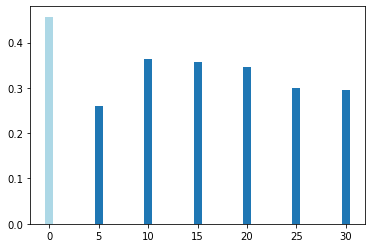

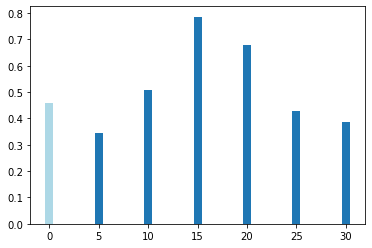

In [512]:
#NN
correls = 0.457085594536686
rates4 = [0.26019494648099106, 0.3647558513182954, 0.3560635540795548, 0.34635974542477693, 0.2995407876910301, 0.29550628196418643]
plt.bar([0],[correls],color='lightblue')
plt.bar(np.arange(5,35,5),rates4)
plt.show()

#Quad
rates3 = [0.3436312392117685, 0.5096493676662128, 0.7860053064097288, 0.6803542119165759, 0.42973240187512596, 0.38578204875294464]
plt.bar([0],[correls],color='lightblue')
plt.bar(np.arange(5,35,5),rates3)
plt.show()

<h2>Recovery Error</h2>

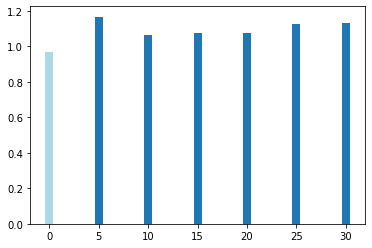

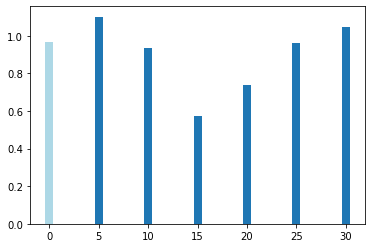

In [508]:
#NN
recov_err = 0.966667441813087
rates2 = [1.167267918674853, 1.0669377129065878, 1.0766506501174677, 1.076044939902739, 1.128652761320835, 1.1309670769096272]
plt.bar([0],[recov_err],color='lightblue')
plt.bar(np.arange(5,35,5),rates2)
plt.show()

#Quad
rates = [1.1010227293796924, 0.932595774435228, 0.5723024078364112, 0.738548230268803, 0.960869985004166, 1.0482262360869552]
plt.bar([0],[recov_err],color='lightblue')
plt.bar(np.arange(5,35,5),rates)
plt.show()

<h2>Sparsity Error</h2>

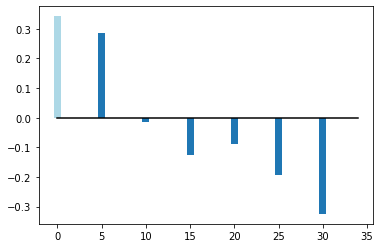

In [525]:
err_spar = 1- 0.6574175053403768
rates5 = np.array([1.285, 0.985, 0.875, 0.9099999999999999, 0.8049999999999999, 0.675])
rates5 -= 1

plt.bar([0],[err_spar],color='lightblue')
plt.bar(np.arange(5,35,5),rates5)

plt.plot(np.arange(35),[0]*35, color='black')
plt.show()

<h2>Success Rates</h2>

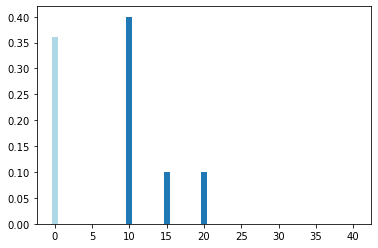

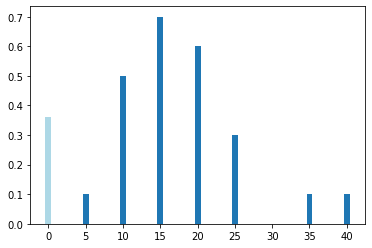

In [78]:
#Success rate comparison
result_classical_NN = 0.36
results_quant_NN = np.array([0, 4, 1, 1, 0, 0, 0, 0])/10
plt.bar([0],[result_classical_NN],color='lightblue')
plt.bar(np.arange(5,45,5),results_quant_NN)
plt.show()

results_quant_quad = np.array([1, 5, 7, 6, 3, 0, 1, 1])/10
plt.bar([0],[result_classical_NN],color='lightblue')
plt.bar(np.arange(5,45,5),results_quant_quad)
plt.show()

---------------------------------------------------------------------------

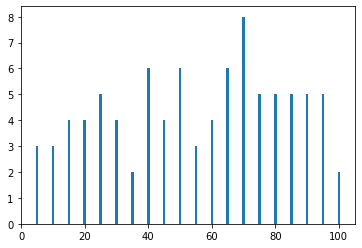

In [19]:
#NN 6qubits 3 picks ---After fix
results9 = [3, 3, 4, 4, 5, 4, 2, 6, 4, 6, 3, 4, 6, 8,5, 5, 5, 5, 5, 2]
plt.bar(np.arange(5,105,5),results9)
plt.show()

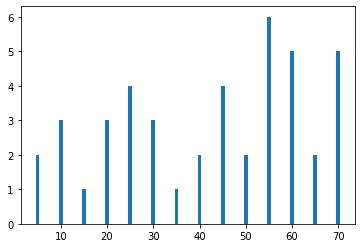

In [17]:
#Random pairs 9 --> fixed
results4 = [2, 3, 1, 3, 4, 3, 1, 2, 4, 2, 6, 5, 2, 5]
plt.bar(train_params,results4)
plt.show()

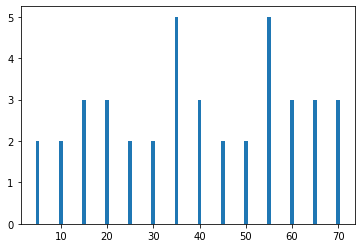

In [32]:
#Random pairs 18 --> fixed
results4 = [2, 2, 3, 3, 2, 2, 5, 3, 2, 2, 5, 3, 3, 3]
plt.bar(train_params,results4)
plt.show()

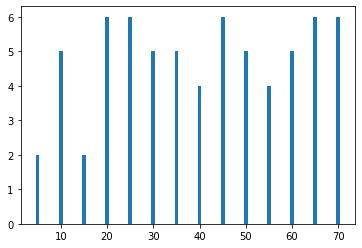

In [15]:
#All possible pairs --> fixed
results1 = [2, 5, 2, 6, 6, 5, 5, 4, 6, 5, 4, 5, 6, 6]
plt.bar(train_params,results1)
plt.show()

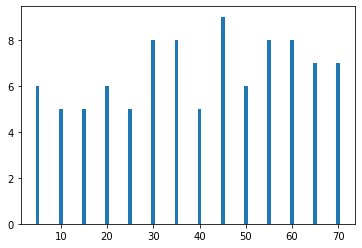

In [18]:
#Triplet NN --> fixed
results8 = [6, 5, 5, 6, 5, 8, 8, 5, 9, 6, 8, 8, 7, 7]
plt.bar(train_params,results8)
plt.show()

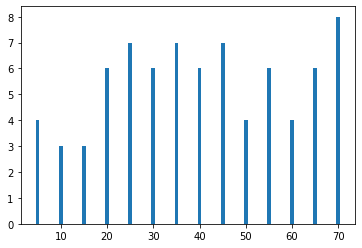

In [15]:
#Random Triplet 9 --> fixed
results3 = [4, 3, 3, 6, 7, 6, 7, 6, 7, 4, 6, 4, 6, 8]
plt.bar(train_params,results3)
plt.show()

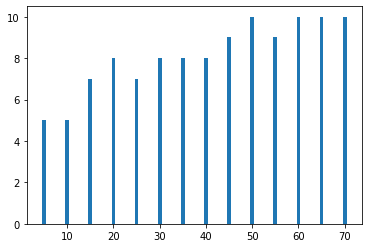

In [15]:
#Random Quadruplet 9 -->fixed
results6 = [5, 5, 7, 8, 7, 8, 8, 8, 9, 10, 9, 10, 10, 10]
plt.bar(train_params,results6)
plt.show()